# Galerkin Approach

Before moving to more difficult differential equations, consider just the following trivial equation

$$
f(x) \approx u(x)
$$

Through the finite element method, we try to approximate $f$ through the approximation $u$, which is a sum of $N$ different prescribed functions $\psi_i(x)$ and unknown coefficients $c_i$:

$$
u(x) = \sum_{i=0}^N c_i \psi_i(x)
$$

## Approximation of Vectors
Consider that $\mathbf{f} = (f_1, f_2)$ is a vector. Let's try to approximate it through  another vector $\mathbf{u}$, which is aligned in the direction of an arbitrary basis $\mathbf{\psi}_0 = (e_1, e_2)$ the vector space $V$.

### Aim
Find the vector $\mathbf{u} = c_0 \mathbf{\psi}_0 \in V$ that is the best approximation to the vector $\mathbf{f}$.

### Criterion
Minimize the length of the difference between approximation $\mathbf{u}$ and solution $\mathbf{f}$.
Herefore, the error $\mathbf{e} = \mathbf{f} - \mathbf{u}$ is introduced, whose length is defined through
$$
||\mathbf{e}|| = (\mathbf{e} \cdot \mathbf{e})^{1/2}
$$

with the inner product 
$$(\mathbf{x} \cdot \mathbf{y}) = \sum_{i=0}^{N} x_i y_i$$

#### The least squares method
In order to minimize $||\mathbf{e}||$ and thereby find $c_0$, which gives the best approximation of $\mathbf{u}$ to $\mathbf{f}$, we introduce the function
$$
E(c_0) = (\mathbf{e} \cdot \mathbf{e}) 
= \left((\mathbf{f} - c_0 \mathbf{\psi}_0) \cdot (\mathbf{f} - c_0 \mathbf{\psi}_0) \right)
= (\mathbf{f} \cdot \mathbf{f}) - 2 c_0 (\mathbf{f} \cdot \mathbf{\psi}_0) 
+ c_0^2 (\mathbf{\psi}_0 \cdot \mathbf{\psi}_0).
$$

To find the optimum value of $c_0$, we have to set the derivative of $E(c_0)$ for $c_0$ to zero:
$$
\frac{\partial E(c_0)}{\partial c_0} = 0 
$$

In this case, this reduces to the following equation:

$$
\frac{\partial E(c_0)}{\partial c_0} = 
- 2 (\mathbf{f} \cdot \mathbf{\psi}_0) 
+ 2 c_0 (\mathbf{\psi}_0 \cdot \mathbf{\psi}_0)
= 0
$$
which can also be written as
$$
\left( (\mathbf{f}- c_0 \mathbf{\psi}_0) \cdot \mathbf{\psi}_0\right) = 0
$$
or 
$$
(\mathbf{e} \cdot \mathbf{\psi}_0 ) = 0
$$

This can be solved for $c_0$:
$$c_0 = \frac{(\mathbf{f} \cdot \mathbf{\psi}_0) }{(\mathbf{\psi}_0 \cdot \mathbf{\psi}_0)}
$$

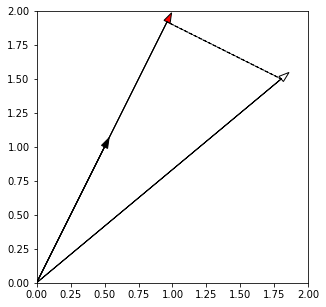

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

'''*********************************************
Function: Compute scalar product between two
          vectors a and b
*********************************************'''
def scalar_product(a, b):
    if (len(a) != len(b)):
        print("Error: Vectors are not of equal size.")
        return None
    else:
        return sum([a[i]*b[i] for i in range(len(a))])

# Define solution vector f
f = (1.8, 1.5)

# Define basis vector
psi_0 = (0.5, 1)

# Compute c_0 value
c_0 = scalar_product(f, psi_0) / scalar_product(psi_0, psi_0)

# Compute approximation to f
u = (c_0*psi_0[0], c_0*psi_0[1])

# Compute error
e = (f[0]-u[0], f[1]-u[1])

fig = plt.figure()
fig.set_size_inches(5,5)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

f_vector   = ax.arrow(0, 0, f[0], f[1], head_width=0.05, fc='w')
psi_vector = ax.arrow(0, 0, psi_0[0],psi_0[1], head_width=0.05, fc='k')
u_vector   = ax.arrow(0, 0, u[0], u[1], head_width=0.05, fc='r')
error      = ax.arrow(u[0], u[1], e[0], e[1], ls='--')

ax.set_xlim([0,2])
ax.set_ylim([0,2])


plt.show()

## Generalization to spaces with arbitrary dimension

We now want to find the approximation $\mathbf{u}$ for an vector $\mathbf{f}$ in the space $V = \text{span}(\mathbf{\psi}_0, ..., \mathbf{\psi}_N)$ of an arbitrary dimension $N+1$. 
The basis vectors $\mathbf{\psi}_0, ..., \mathbf{\psi}_N$ are chose to be linearly independent.

The approximation vector $\mathbf{u}$ can be written as 
$$
\mathbf{u} = \sum_{j=0}^{N} c_j \mathbf{\psi}_j
$$

### Least squares method for vectors of arbitrary dimension
Again the error that will be minimized is defined as $\mathbf{e} = \mathbf{f} - \mathbf{u}$. 
Next, the squared distance is defined as
$$
E(c_0, ..., c_1) 
= (\mathbf{e} \cdot \mathbf{e}) 
= \left( \mathbf{f} \cdot \mathbf{f} \right) 
- 2 \sum_{j}^N c_j (\mathbf{f} \cdot \mathbf{\psi}_j )
+ \sum_{p}^N \sum_{q}^N c_p c_q (\mathbf{\psi}_p \cdot \mathbf{\psi}_q)
$$
In order to minimize $E$, its derivatives for all $c_i$ is set to zero
$$
\frac{\partial E}{\partial c_i} = 0, \quad i=0,...,N
$$

Differentiation of all terms leads to the following system of $N+1$ linear equations:
$$
\sum_{j=0}^{N} A_{i,j} c_j = b_i, \quad i=0,...,N
$$
with
$$
A_{i,j} = (\mathbf{\psi}_i \cdot \mathbf{\psi}_j)
$$
and
$$
b_i = (\mathbf{\psi}_i \cdot \mathbf{f} )
$$

## Approximation of functions
Now consider a set of $N+1$ basis functions $\psi_0, ..., \psi_N$, which form a so called function space $V = \text{span}(\psi_0, ..., \psi_N)$.
Any function $u$ can now be written as a weighted sum of all basis functions $\psi_i$ from the function space $V$.
$$
u = \sum_{j=0}^N c_j \psi_j
$$

### The least squares method
The task is now, to find the right values of $c_j$ in order to approximate $u$ with the smallest possible error to a given function $f$.
For now we look at functions that vary only in a single variable $x$, e.g. $u(x), f(x),...$

The norm for measuring the distance between $u(x)$ and $f(x)$ will now be defined through
$$
E = (e(x) \cdot e(x)) = \int_{\Omega} e(x) e(x) \text{d}x
$$
with $e(x) = f(x) - u(x)$.
This formulation can be rearranged to
$$
E(c_i, ..., c_N) = (f\cdot f) - 2 \sum_{j=0}^N c_j (f \cdot \psi_i) \sum_{p=0}^N \sum_{q=0}^N c_p c_q (\psi_p \cdot \psi_q)
$$

Again, this function is minimized through setting its derivatives for $c_i$ to zero. This leads again to a linear equation system (as in the vector space case) of the form
$$
\mathbf{A} \mathbf{x} = \mathbf{b}
$$

with the coefficients
$$
A_{ij} = (\psi_i \cdot \psi_j)
$$
$$
b_i = (f \cdot \psi_i)
$$


### Example
$$
f(x) = 10(x-1)^2 - 1, \qquad x \in \Omega = \left[1,2\right]
$$

Find the best approximation $u(x)$ in the space of all linear functions:

$$
V = \text{span}(1,x)
$$



A:
[[ 0.91652498  0.10400247 -0.63479507]
 [ 0.10400247  0.28172991 -0.0075771 ]
 [-0.63479507 -0.0075771   0.52142978]]
b:
[ 2.26198491 -1.22828473 -1.72687167]


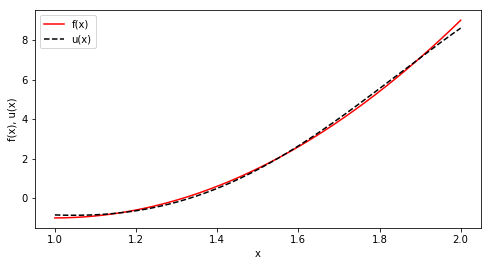

In [115]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt

#-------------------------------------------------------
def convolute(f, g, Omega):
    '''Calculates the integral over f*g over the domain 
    omega=(x_start, x_end)'''    
    return integrate.quad(lambda x: f(x) * g(x), Omega[0], Omega[1])[0]

#-------------------------------------------------------
def init_A(psi, Omega, N):
    '''Sets up the matrix "A" of the linear 
    equation system'''
    A = np.zeros((N+1,N+1))
    for i in range(N+1):
        for j in range(N+1):
            A[i][j] = convolute(psi(i), psi(j), Omega)
    return A
    
#-------------------------------------------------------
def init_b(f, psi, Omega, N):
    '''Sets up the right hand side "b" of the linear 
    equation system'''
    b = np.zeros(N+1)
    for i in range(N+1):
        b[i] = convolute(f, psi(i), Omega)
    return b

#-------------------------------------------------------
def least_squares(f, psi, x, N, **kwargs):
    '''Sets up and solves the linear equation and returns 
    the c_i values and the approximation u(x)'''
    # Determine function space
    #---------------------------------------------------
    Omega = (x[0], x[-1])
    
    # Set up the linear equation system
    #---------------------------------------------------
    A = init_A(psi, omega, N)
    b = init_b(f, psi, Omega, N)
    
    if (kwargs.get('show_A', False)):
        print("A:")
        print(A)
    if (kwargs.get('show_b', False)):
        print("b:")
        print(b)
    
    # Solve the linear equation system
    #---------------------------------------------------
    try:
        c =  np.linalg.solve(A, b)
    except:
        c = [b[i] / A[i][i] for i in range(N+1)] 
    
    # Calculate the approximation function u(x)
    #--------------------------------------------------- 
    u  = sum(c[i]*psi(i)(x) for i in range(0, N+1))

    return (u, c)



# Import additional numpy functions and constants
#-------------------------------------------------------
from numpy import tanh, cos, sin, pi

# Define the basis functions
#-------------------------------------------------------
def psi(i):
    '''This function returns the psi basis functions'''
    #return lambda x: x**i
    return lambda x: sin((i+1)*x)

# Define the function f(x)
#-------------------------------------------------------
f = lambda x: 10.*(x-1.)**2 - 1.

# Define the upper and lower bound of f(x)
#-------------------------------------------------------
x = np.linspace(1, 2, 501)
N = 2

# Compute least squares approximation to f(x)
#-------------------------------------------------------
(u, c) = least_squares(f, psi, x, N, show_A=True, show_b=True)


# Plot results
#-------------------------------------------------------
fig = plt.figure()
fig.set_size_inches(8,4)
ax = fig.add_subplot(111)
f_plt = ax.plot(x, f(x), c='r', ls='-', label='f(x)')
u_plt = ax.plot(x, u, c='k', ls='--', label='u(x)')
ax.set_xlabel('x') 
ax.set_ylabel('f(x), u(x)')
ax.legend()
plt.show()


[-1.0706817  -0.23112637 -0.22962645 -0.15494506 -0.12769095 -0.10558575
 -0.09066567 -0.07929121 -0.07048563 -0.06343343 -0.05766571]


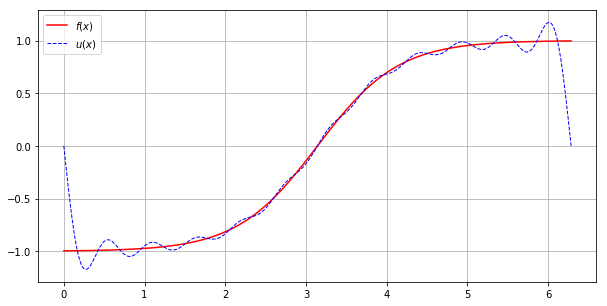

In [91]:
import numpy as np

def least_squares_numerical(f, psi, N, x, 
                            integration_method='scipy',
                            orthogonal_basis=False):
    import scipy.integrate
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)
    # Integration range
    Omega = [x[0], x[-1]]
    dx = x[1] - x[0]
    
    for i in range(0, N+1):
        
        # Compute entries of matrix A
        j_limit = i+1 if orthogonal_basis else N+1
        for j in range(i, j_limit):
            if (integration_method == 'scipy'):
                A_ij = scipy.integrate.quad(
                        lambda x: psi(x,i) * psi(x,j),
                        Omega[0], Omega[1], epsabs=1e-9, epsrel=1e-9)[0]
            else:
                values = psi(x,i) * psi(x,j)
                A_ij = trapezoidal(values, dx)
                
            A[i][j] = A[j][i] = A_ij
            
        # compute entries of rhs b
        if (integration_method == 'scipy'):
            b_i = scipy.integrate.quad(
                    lambda x: f(x)*psi(x,i),
                    Omega[0], Omega[1], epsabs=1e-9, epsrel=1e-9)[0]
        else:
            values = psi(x,i) * f(x)
            b_i = trapezoidal(values, dx)
        b[i] = b_i
        
    c = b / np.diag(A) if orthogonal_basis else np.linalg.solve(A, b)
    u  = sum(c[i]*psi(x, i) for i in range(0, N+1))
    return u, c

def trapezoidal(values, dx):
    """Integrate values by trapezoidal rule"""
    return dx*(np.sum(values) - 0.5*values[0] - 0.5*values[-1])





from numpy import linspace, tanh, pi, sin

def psi(x, i):
    return sin((i+1)*x)
    #return x**i
    
x = linspace(0, 2*pi, 501)
N = 10
f = lambda x: tanh(x-pi)
#f = lambda x: 10. * (x-1.)**2 - 1


u, c = least_squares_numerical(f, psi, N, x, 
                               integration_method='scipy',
                               orthogonal_basis=True)

print(c)


from matplotlib import pyplot as plt

fig = plt.figure()
fig.set_size_inches(10,5)
ax = fig.add_subplot(111)

f_plt = ax.plot(x, f(x), c='r', lw=1.5, ls='-', label=r'$f(x)$')
u_plt = ax.plot(x, u, c='b', lw=1.0, ls='--', label=r'$u(x)$')

legend = plt.legend()

ax.grid(True)

plt.show()

# Using Lagrange Polynomials

In [104]:
''' Compute lagrangian interpolation polynomial over domain x at specific points '''
def Lagrange_polynomial(x, i, points):
    p = 1
    for k in range(len(points)):
        if k != i:
            p *= (x - points[k]) / (points[i] - points[k])
    return p

def Chebyshev_nodes(a, b, N):
    from math import cos, pi
    return [0.5*(a+b) + 0.5*(b-a)*cos((2.*i+1.)/(2.*(N+1.))*pi) for i in range(N+1)]


''' Compute complete basis of lagrange polynomials at specified points '''
def Lagrange_polynomials_01(x, N, Omega, point_distribution='uniform'):
    if point_distribution == 'uniform':
        h = 1.0 / (N-1)
        points = [i*h for i in range(N+1)]

    elif point_distribution == 'Chebyshev':
        points = Chebyshev_nodes(Omega[0], Omega[1], N)
        
    psi = [Lagrange_polynomial(x, i, points) for i in range(N)]
    return psi, points


x = np.linspace(0,1,10)
psi, points = Lagrange_polynomials_01(x, 
                                      Omega=(0,1), 
                                      N=3, 
                                      point_distribution='Chebyshev')

print(points)

[0.9619397662556434, 0.6913417161825449, 0.30865828381745514, 0.03806023374435663]


# Finite Element Introduction

In [106]:
# Defining the mesh
nodes = [0, 0.2, 0.4, 0.7, 1.0]
elements = [[0,1,2],[2,3,4]]



In [37]:
a = lambda x: x**2

b = 2*a(np.linspace(0,1,500))
